# 1- instal the labrary that we need 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 2- Data Preparation:

- Load the MNIST dataset.
- Preprocess data as needed (flatten, normalize, train/test split).

In [3]:
random_state= 42
np.random.seed(random_state)


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)


X = (X / 255.0).astype("float32")           
y = y.astype("int64")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, stratify=y, random_state=random_state
)

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (60000, 784)  Test: (10000, 784)


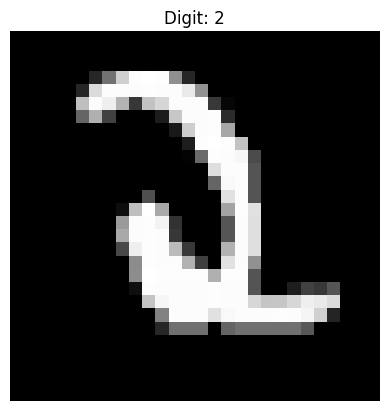

In [4]:
image_index = 400
image_data = X[image_index].reshape(28, 28)

# Display the image
plt.imshow(image_data, cmap='gray') # 'gray_r' for reversed grayscale (black digits on white background)
plt.title(f"Digit: {y[image_index]}") # Display the corresponding digit label
plt.axis('off') # Turn off axis labels for a cleaner image display
plt.show()

# 3- Model Training:

#### Train the following classifiers:
- Logistic Regression
- Support Vector Machine (SVM)
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier

In [5]:
import sys, subprocess


subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])


import xgboost as xgb
print("XGBoost version:", xgb.__version__)
from xgboost import XGBClassifier
print("✅ Ready: XGBClassifier import works")


XGBoost version: 3.0.5
✅ Ready: XGBClassifier import works


In [6]:
# (Optional) Enable PCA to speed up training and help convergence
USE_PCA = False   # Change to True if you want to use PCA
PCA_COMPONENTS = 50
if USE_PCA:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
    X_train = pca.fit_transform(X_train)
    X_test  = pca.transform(X_test)

# Try to import XGBoost (will only be used if available)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print("⚠️ xgboost not installed or not available in this kernel.")

# 1) Define models — LogisticRegression updated to avoid convergence warning
models = {
    "LogisticRegression": LogisticRegression(
        solver="saga", max_iter=600, tol=1e-3, C=0.5, n_jobs=-1, random_state=42
    ),
    "LinearSVM": LinearSVC(dual=False, random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=20, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
}

if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=10,
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
    )

# 2) Train models
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"✅ Trained: {name}")

trained_models


✅ Trained: LogisticRegression
✅ Trained: LinearSVM
✅ Trained: DecisionTree
✅ Trained: RandomForest
✅ Trained: XGBoost


{'LogisticRegression': LogisticRegression(C=0.5, max_iter=600, n_jobs=-1, random_state=42,
                    solver='saga', tol=0.001),
 'LinearSVM': LinearSVC(dual=False, random_state=42),
 'DecisionTree': DecisionTreeClassifier(max_depth=20, random_state=42),
 'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
          

# 4- Model Evaluation:

- classification report (precision, recall, F1-score) for each model.

In [7]:
# ===== Model Evaluation: reports + comparison table =====
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

all_results = {}
summary_rows = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test)

    # 1) Print classification report
    print("\n" + "="*70)
    print(f"{name} — Classification Report")
    print("="*70)
    print(classification_report(y_test, y_pred, digits=4))

    # 2) Store metrics for comparison
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    all_results[name] = {
        "y_pred": y_pred,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "estimator": model,
    }

    summary_rows.append({
        "Model": name,
        "Accuracy": acc,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
    })

# 3) Comparison table
summary_df = pd.DataFrame(summary_rows).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("\nSummary (sorted by Accuracy):")
display(summary_df)

# 4) (optional) Save to CSV
# summary_df.to_csv("mnist_model_comparison.csv", index=False)



LogisticRegression — Classification Report
              precision    recall  f1-score   support

           0     0.9590    0.9726    0.9658       986
           1     0.9499    0.9769    0.9632      1125
           2     0.9306    0.8999    0.9150       999
           3     0.8982    0.8824    0.8902      1020
           4     0.9309    0.9251    0.9280       975
           5     0.8884    0.8825    0.8854       902
           6     0.9366    0.9623    0.9493       982
           7     0.9380    0.9434    0.9407      1042
           8     0.9012    0.8790    0.8899       975
           9     0.8942    0.9014    0.8978       994

    accuracy                         0.9236     10000
   macro avg     0.9227    0.9225    0.9225     10000
weighted avg     0.9234    0.9236    0.9234     10000


LinearSVM — Classification Report
              precision    recall  f1-score   support

           0     0.9451    0.9777    0.9611       986
           1     0.9467    0.9787    0.9624      1125

,Model,Accuracy,F1_macro,F1_weighted
0,XGBoost,0.9756,0.975447,0.975591
1,RandomForest,0.9679,0.967640,0.967886
2,LogisticRegression,0.9236,0.922525,0.923383
3,LinearSVM,0.9161,0.914713,0.915726
4,DecisionTree,0.8812,0.879348,0.881050


# 5- Error Analysis:

- Plot these images along with:
-True label
-Predicted label

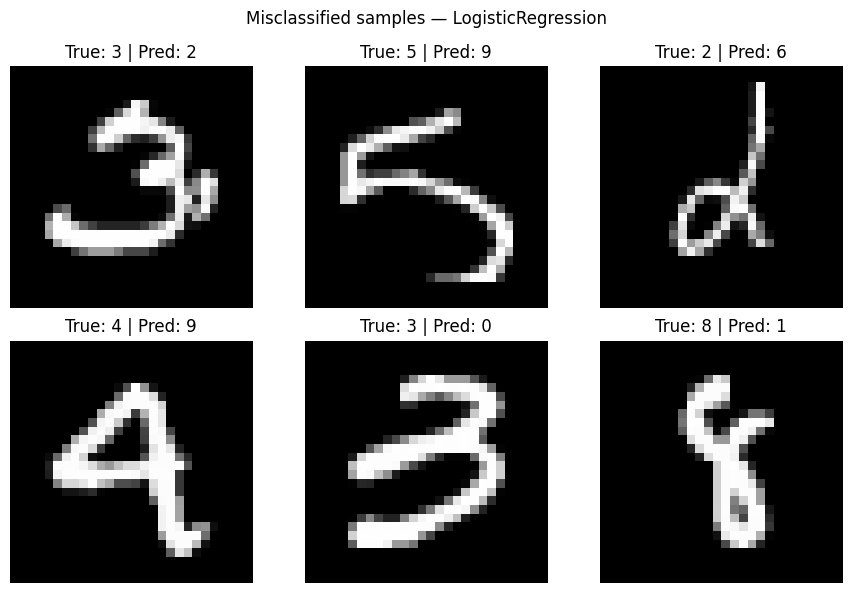

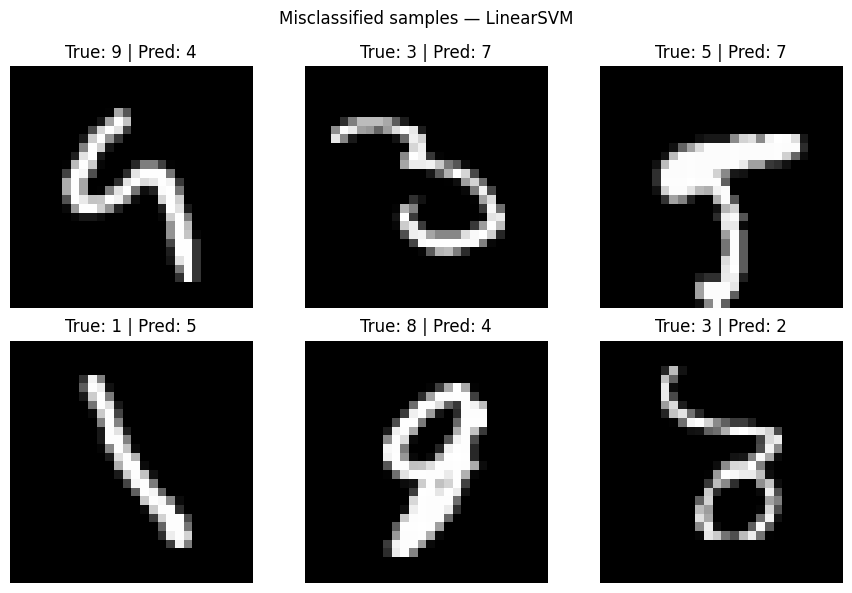

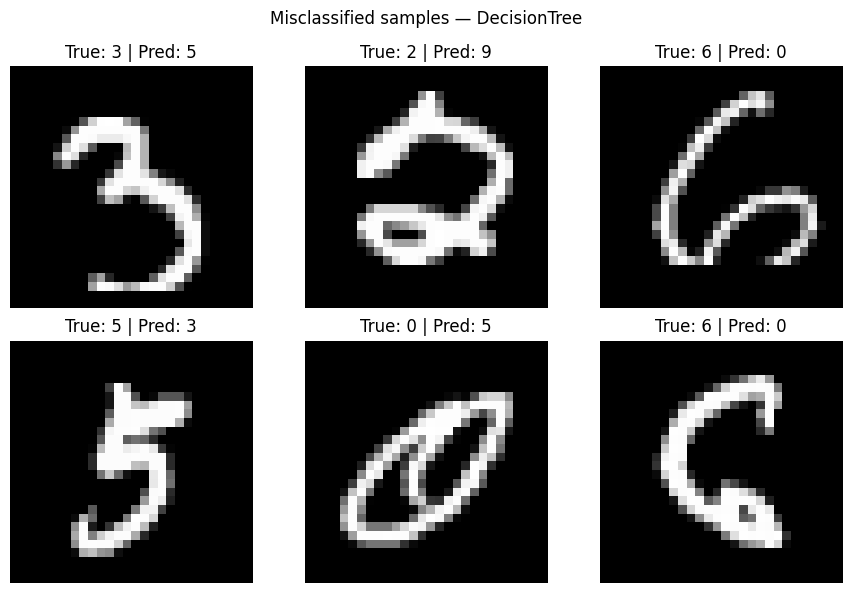

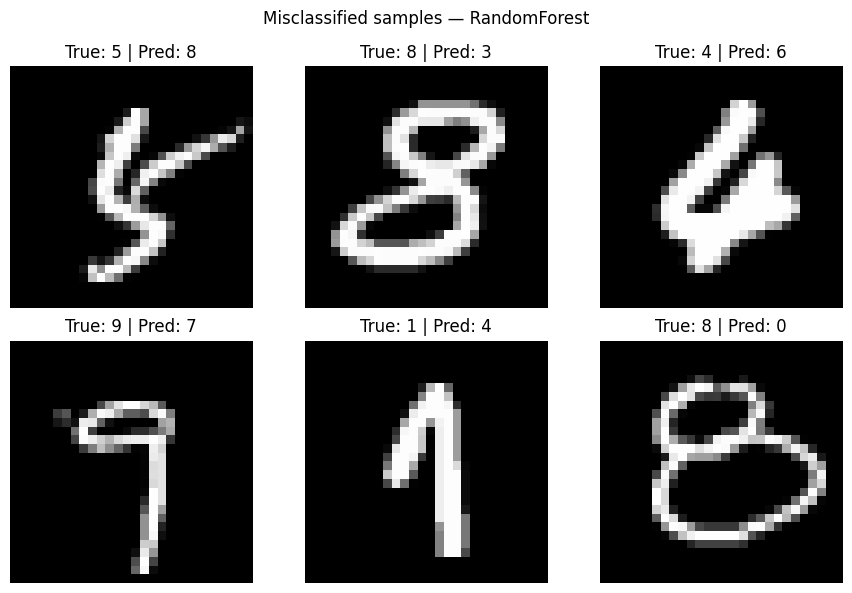

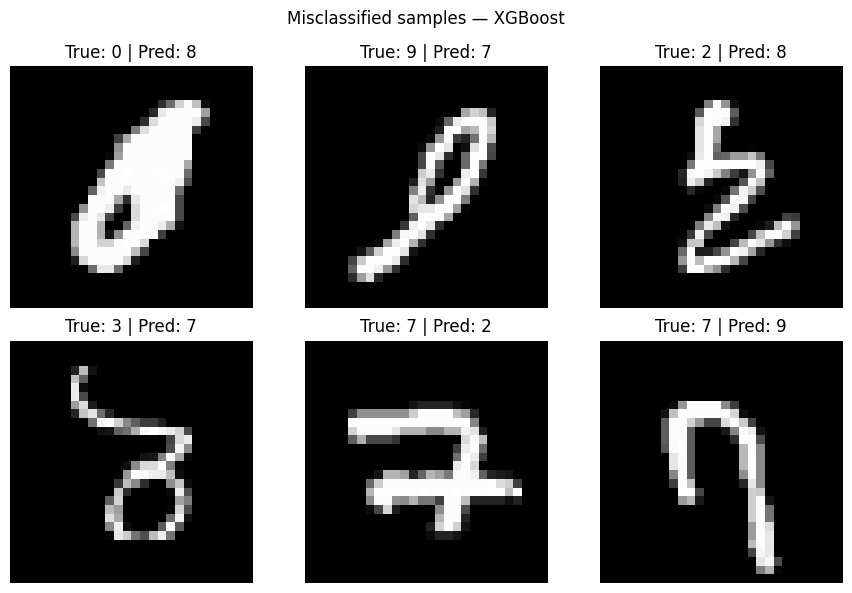

In [8]:
X_pixels = globals().get("X_test_pixels", X_test)

def show_misclassified_grid(model_name, y_true, y_pred, X_flat, n=8, cols=4):
    mis_idx = np.where(y_pred != y_true)[0]
    if len(mis_idx) == 0:
        print(f"{model_name}: no misclassifications 🎉")
        return
    n = min(n, len(mis_idx))
    # deterministic sample for reproducibility
    rng = np.random.RandomState(42)
    pick = rng.choice(mis_idx, size=n, replace=False)

    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = np.array(axes).reshape(-1)

    for ax_i, idx in enumerate(pick):
        img = X_flat[idx].reshape(28, 28)
        axes[ax_i].imshow(img, cmap="gray")
        axes[ax_i].set_title(f"True: {y_true[idx]} | Pred: {y_pred[idx]}")
        axes[ax_i].axis("off")

    # Hide any leftover axes
    for k in range(len(pick), len(axes)):
        axes[k].axis("off")

    plt.suptitle(f"Misclassified samples — {model_name}", y=0.98)
    plt.tight_layout()
    plt.show()

# If you already created predictions in a dict (e.g., all_results[name]["y_pred"]), reuse them.
# Otherwise we compute them below.
try:
    preds_dict = {name: dct["y_pred"] for name, dct in all_results.items()}
except Exception:
    preds_dict = {name: model.predict(X_test) for name, model in trained_models.items()}

# Show 6 misclassified images per model (change n as you like: 5–10 recommended)
for name, y_pred in preds_dict.items():
    show_misclassified_grid(name, y_test, y_pred, X_pixels, n=6, cols=3)


# 6- Output & Visualization:

- summary comparison of all models

In [11]:
summary_df = pd.DataFrame(summary_rows).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("\nSummary (sorted by Accuracy):")
display(summary_df)


Summary (sorted by Accuracy):


,Model,Accuracy,F1_macro,F1_weighted
0,XGBoost,0.9756,0.975447,0.975591
1,RandomForest,0.9679,0.967640,0.967886
2,LogisticRegression,0.9236,0.922525,0.923383
3,LinearSVM,0.9161,0.914713,0.915726
4,DecisionTree,0.8812,0.879348,0.881050


- Display misclassified samples with matplotlib.
- Plot confusion matrices for each model.

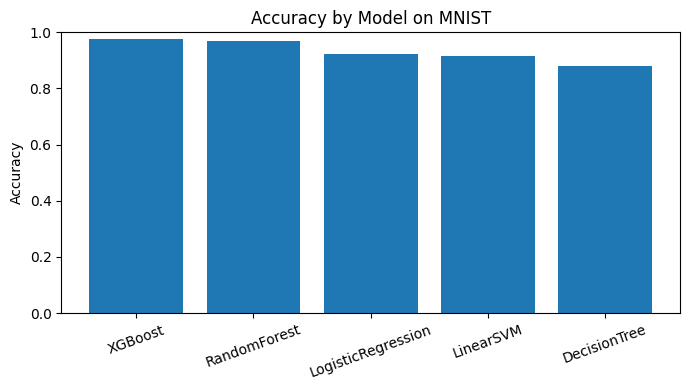

In [10]:
# Accuracy bar chart
plt.figure(figsize=(7,4))
plt.bar(summary_df["Model"], summary_df["Accuracy"])
plt.title("Accuracy by Model on MNIST")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()